### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [0]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [0]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [0]:
from torchvision.models.inception import inception_v3
from torchvision.models.resnet import resnet50

# model = inception_v3(pretrained=True,      # load existing weights
#                      transform_input=True, # preprocess input image the same way as in training
#                     )
# model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)

model = resnet50(pretrained=True,progress=True)
model.train(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
import torch

dummy_x = torch.randn(5, 3, 224, 224)
model(dummy_x)

tensor([[-0.6434,  0.1436, -0.2651,  ..., -2.6069, -0.8802,  1.3746],
        [-0.6882,  0.0758, -0.1429,  ..., -2.3333, -1.1926,  1.3379],
        [-0.8267, -0.0884, -0.1255,  ..., -2.5526, -0.8090,  1.2976],
        [-0.6997,  0.0406,  0.2613,  ..., -2.6090, -1.1949,  1.5604],
        [-0.5543,  0.0670,  0.0954,  ..., -2.5842, -1.1342,  1.1747]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [0]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2020-03-14 12:18:04--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2020-03-14 12:18:04 (107 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



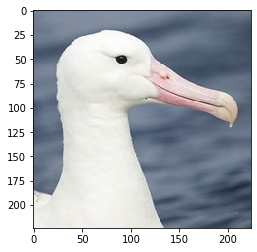

top-10 classes are: 
 [prob : class label]
0.9938 :	albatross
0.0023 :	spoonbill
0.0011 :	hammerhead
0.0006 :	American egret
0.0005 :	goose
0.0003 :	pelican
0.0003 :	oystercatcher
0.0002 :	ptarmigan
0.0001 :	crane


In [0]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (224, 224))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 224, 224, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [0]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2020-03-14 12:18:08--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.26.4.67, 104.26.5.67, 2606:4700:20::681a:543, ...
Connecting to cdn.com.do (cdn.com.do)|104.26.4.67|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2020-03-14 12:18:08--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.26.4.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49327 (48K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  48.17K  --.-KB/s    in 0.001s  

2020-03-14 12:18:08 (32.7 MB/s) - ‘img.jpg’ saved [49327/49327]



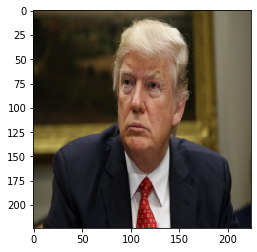

top-10 classes are: 
 [prob : class label]
0.4820 :	suit
0.4616 :	Windsor tie
0.0227 :	bolo tie
0.0054 :	lab coat
0.0054 :	groom
0.0031 :	bow tie
0.0017 :	hourglass
0.0016 :	trench coat
0.0009 :	stethoscope


In [0]:
img = resize(plt.imread('img.jpg'), (224, 224))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [0]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip -n data.zip

File ‘data.zip’ already there; not retrieving.
Archive:  data.zip


### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [0]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [0]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity

embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

embedding = embedding.cuda()

print("success")

success


# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [0]:
#extract features from images
from tqdm import tqdm_notebook as tqdm
from skimage.io import imread
import PIL.Image as Image
import os
import numpy as np


X = []
Y = []

batch_size = 64
imgs = np.zeros([batch_size, 224, 224, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32).cuda()
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor).detach().cpu().numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

In [0]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24960, 2048) (24960,)


In [0]:
#<split data here or use cross-validation>
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [0]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [0]:
from sklearn.metrics import classification_report, confusion_matrix


In [0]:
clf = LogisticRegression(max_iter=50)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      2464
        True       0.98      0.98      0.98      2528

    accuracy                           0.98      4992
   macro avg       0.98      0.98      0.98      4992
weighted avg       0.98      0.98      0.98      4992

[[2413   51]
 [  47 2481]]


In [0]:
pred_val = clf.predict(X_val)
print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val,pred_val))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      2461
        True       0.98      0.98      0.98      2531

    accuracy                           0.98      4992
   macro avg       0.98      0.98      0.98      4992
weighted avg       0.98      0.98      0.98      4992

[[2415   46]
 [  49 2482]]


In [0]:
from sklearn.neighbors import NearestNeighbors

In [0]:
nn = NearestNeighbors(metric = 'euclidean')
nn.fit(X )

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
files = os.listdir('train')

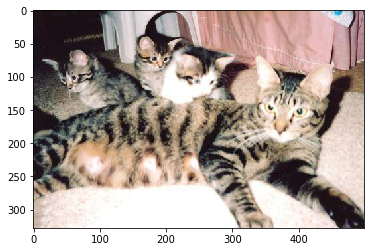

In [0]:
i = 50

img = imread(os.path.join("train", files[i]))
plt.imshow(img)
plt.show()

In [0]:
from IPython.display import Image as ImageD
from IPython.display import display

In [0]:
from PIL import Image

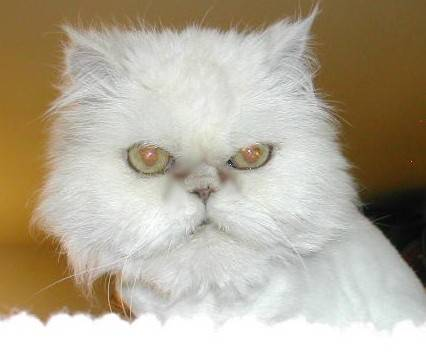

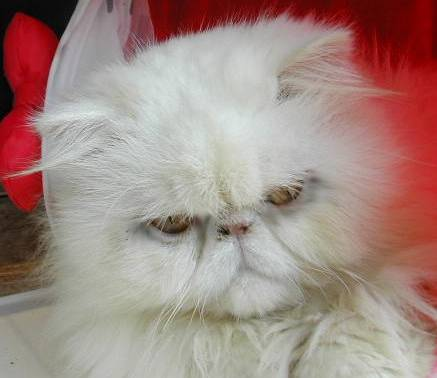

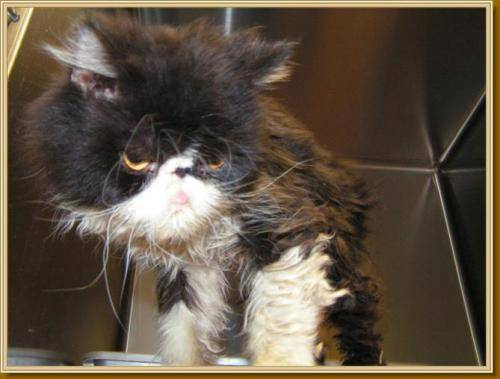

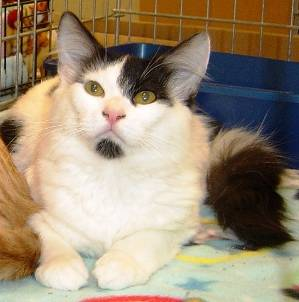

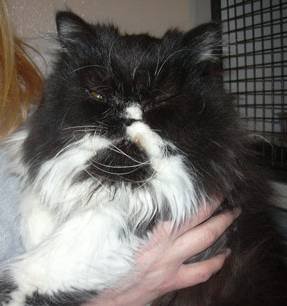

In [0]:
i = 3210

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRpi-qWdnwvyrhwA-1nn3le4EXhBZVJLskADR_uSl5FZflXH1uxig&s"
img = imread(url)
img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
img = img.reshape((1,224,224,3))

input_tensor = torch.as_tensor(img.transpose([0,3,1,2]), dtype=torch.float32).cuda()
    
        # use your embedding model to produce feature vector
features = embedding(input_tensor).detach().cpu().numpy()
        
#x = embedding(img)

pred = nn.kneighbors(features.reshape(1,-1), n_neighbors=5)
ids = pred[1].reshape(-1)

display(ImageD(url=url))
for j in ids:
  display(ImageD(os.path.join("train", files[j])))

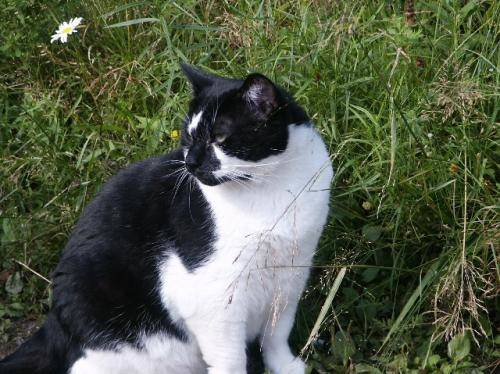

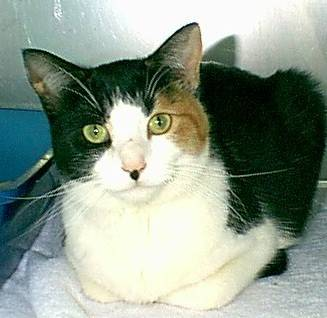

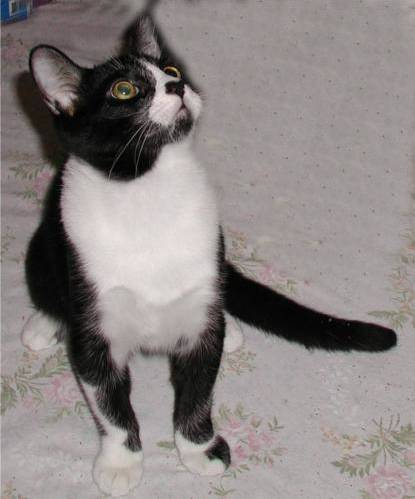

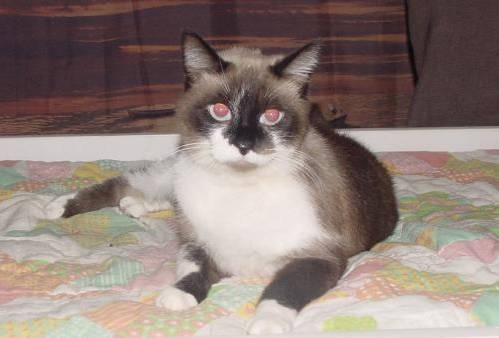

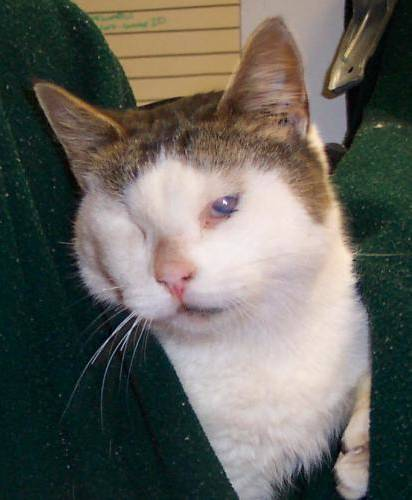

In [0]:
i = 3210

pred = nn.kneighbors(X[i].reshape(1,-1), n_neighbors=5)
ids = pred[1].reshape(-1)

for j in ids:
  display(Image(os.path.join("train", files[j])))

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [0]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [0]:
modulelist = list(model.children())

In [0]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [0]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [0]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [0]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

In [0]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [0]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [0]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [0]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)
img_adv

In [0]:
predict(resize(np.asarray(img_adv), (299, 299)))